# 4. Re-evaluation under deep uncertainty

Optimizing generates a set of promising strategies that illustrate the key trade-offs on the relevant objectives (J.H.Kwakkel, Walker, et al. 2016). To counter scenario dependency that might result from optimizing policies only on the five previously selected worst-case scenarios, the identified policies were tested over the various deeply uncertain factors to assess their robustness against uncertainties. A larger scenario sampling also allows us to obtain a more representative value of the robustness of each policy.




# 1.1 Generate random policies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator,
                           Constraint, Policy, Scenario)
from ema_workbench.analysis import parcoords


from problem_formulation import get_model_for_problem_formulation

import time

Re-evaluation

In [2]:
## 


# results_deep = []
# convergence_all = []

# for i in range(5):
#     print(i)
#     result, convergence = load_results(f'../results/mordm_7500_rp_scenario{i}.tar.gz')
#     results_deep.append(result)
#     convergence_all.append(convergence)



# policies = []
# for i, result in enumerate(results_deep):
#     outcomes_of_interest = result.iloc[:, :-3]
#     for j, row in outcomes_of_interest.iterrows():
#         policy = Policy(f'scenario {i} policy {j}', **row.to_dict())
#         policies.append(policy)




# We use the original problem formulation to account for the RfR policies
# dike_model, planning_steps = get_model_for_problem_formulation(2)

# ema_logging.log_to_stderr(ema_logging.INFO)

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     reeevaluation_results = evaluator.perform_experiments(500, policies=policies)
    
# experiments_reev, outcomes_reev = reeevaluation_results

# from ema_workbench import save_results
# save_results((experiments_reev, outcomes_reev), f'../results/mordm_exp_2_1000.tar.gz')

In [3]:
# We use the original problem formulation to account for the RfR policies
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [4]:
experiments_reev, outcomes_reev = load_results('../results/mordm_exp_2_1000.tar.gz') 
outcomes_reev_df = pd.DataFrame.from_dict(outcomes_reev)

Comparing both cells below we can see how we have 42 unique policies.

In [5]:
experiments_reev.iloc[:,19:-3].duplicated().value_counts()

True     20958
False       42
dtype: int64

In [6]:
experiments_reev['policy'].nunique()

42

We now only chose the policies that keep the number of deaths under the threshold in ALL scenarios

In [7]:
outcomes_reev_df.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,2.100000e+04,2.100000e+04,2.100000e+04,21000.000000,21000.000000
mean,9.174717e+07,9.998493e+07,1.751971e+09,3407.984925,0.009067
std,3.406452e+08,2.086492e+07,2.994190e+08,7980.440903,0.030620
min,0.000000e+00,6.087036e+07,9.759000e+08,0.000000,0.000000
25%,1.544874e+06,8.173593e+07,1.572700e+09,112.189787,0.000105
50%,1.299621e+07,1.017962e+08,1.828800e+09,831.723645,0.001412
75%,4.840653e+07,1.158001e+08,2.015900e+09,2762.519602,0.005346
max,3.043916e+09,1.380248e+08,2.131200e+09,117778.445391,0.464258


In [8]:
outcomes_reev_df['policy']= experiments_reev['policy']
policy_names = outcomes_reev_df.policy.unique()

max_num_deaths = 0.0001 * 3 * 5

policies_of_interest = []
for policy in policy_names:
    policy_df = outcomes_reev_df[outcomes_reev_df['policy'] == policy]
    policy_df_logical = policy_df['Expected Number of Deaths'] > max_num_deaths
    type(policy_df_logical)
    if policy_df_logical.any():
        continue
    else:
        policies_of_interest.append(policy)

policies_of_interest

[]

We can see that there is no policy that obeys the threshold under all scenarios. We therefore calculate the robustness using the thresholds. This gives us an idea of how far off we are.

In [9]:
outcomes_reev_df_death= outcomes_reev_df[outcomes_reev_df['Expected Number of Deaths']<=max_num_deaths]
len(outcomes_reev_df_death)

10610

In [10]:
import functools

def robustness(direction, threshold, data):
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def dummy(data):
    return data[0] # makes numbers nicer CAREFUL WITH UNITS
    
SMALLER = 'SMALLER'


max_num_deaths = 0.0001 * 3 * 5
max_rfr_costs = 1.1e9
max_dike_costs = 3.04e8

Expected_Annual_Damage = dummy
Dike_Investment_Costs = functools.partial(robustness, SMALLER, max_dike_costs)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, max_num_deaths)
RfR_Investment_Costs = functools.partial(robustness, SMALLER, max_rfr_costs)
Evacuation_Costs = dummy

No handles with labels found to put in legend.


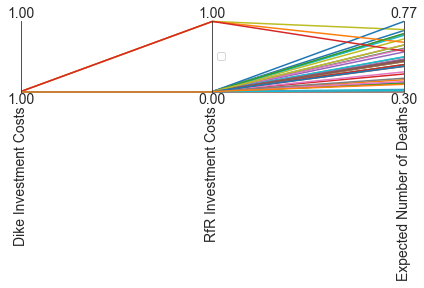

In [11]:
from ema_workbench.analysis import parcoords
import matplotlib.lines as mlines


funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths,
         'RfR Investment Costs':RfR_Investment_Costs,       
         'Evacuation Costs': Evacuation_Costs}

total_scores = {}
for policy in experiments_reev.policy.unique():
    scores = {}
    logical = experiments_reev['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes_reev.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data_domain = pd.DataFrame(total_scores).T#.reset_index(drop=True)
data_domain = data_domain.drop(data_domain.columns[0], axis=1)
data_domain = data_domain.drop(data_domain.columns[-2], axis=1)
limits = parcoords.get_limits(data_domain)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_domain)
plt.legend()
plt.show()

In [12]:
data_death = data_domain.sort_values(by=['Expected Number of Deaths']).tail()
data_death

,Dike Investment Costs,RfR Investment Costs,Expected Number of Deaths
scenario 2 policy 9,1.0,0.0,0.684
scenario 3 policy 4,1.0,0.0,0.686
scenario 0 policy 0,1.0,0.0,0.706
scenario 3 policy 0,1.0,1.0,0.712
scenario 3 policy 2,1.0,0.0,0.766


These are the 5 policies that are the most robust in terms of Death mitigation

In [13]:
data_rfr = data_domain[data_domain['RfR Investment Costs'] == 1.0]
data_rfr

,Dike Investment Costs,RfR Investment Costs,Expected Number of Deaths
scenario 3 policy 0,1.0,1.0,0.712
scenario 3 policy 3,1.0,1.0,0.628
scenario 3 policy 5,1.0,1.0,0.570


These are the policies which are below the RfR investment cost threshold defined by RWS. Since we want to propose a policy that is likely to be approved by the RWS, the policies that are the RfR investment costs threshold are chosen for further investigation. Additionally, the best performing policy in terms of Death Minimalization is also further investigated, due to it meeting the threshold set by the Delta Commission. 

In [14]:
potential_policies = [policy for policy in data_rfr.index]
potential_policies.append(data_death.index[-1])

df_potential_policies = outcomes_reev_df[outcomes_reev_df['policy'].isin(potential_policies)]

In [15]:
df_potential_policies.to_csv('../results/outcomes_reev_df.csv')

In [16]:
data_policies = data_domain[data_domain.index.isin(potential_policies)]
data_policies

,Dike Investment Costs,RfR Investment Costs,Expected Number of Deaths
scenario 3 policy 0,1.0,1.0,0.712
scenario 3 policy 2,1.0,0.0,0.766
scenario 3 policy 3,1.0,1.0,0.628
scenario 3 policy 5,1.0,1.0,0.570


In [17]:
policy1_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[0]].iloc[:,:-1]
policy2_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[1]].iloc[:,:-1]
policy3_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[2]].iloc[:,:-1]
policy4_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[3]].iloc[:,:-1]

frames = [policy1_df,policy2_df,policy3_df,policy4_df]
all_data = pd.concat(frames)

C:\Users\Willy\Anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Willy\Anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:261: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


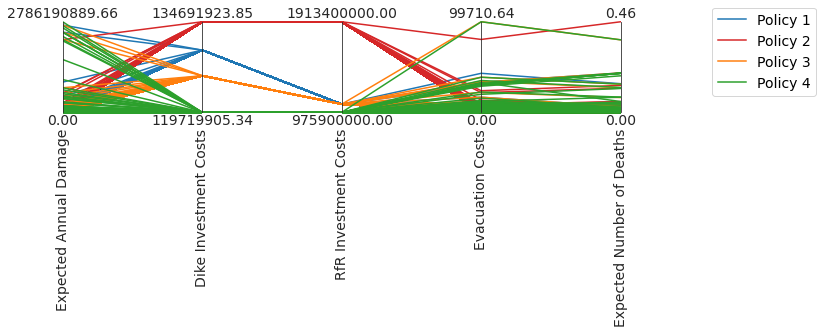

In [20]:

policy1_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[0]].iloc[:,:-1]
policy2_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[1]].iloc[:,:-1]
policy3_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[2]].iloc[:,:-1]
policy4_df = outcomes_reev_df[outcomes_reev_df['policy']==potential_policies[3]].iloc[:,:-1]

frames = [policy1_df,policy2_df,policy3_df,policy4_df]
all_data = pd.concat(frames)

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)
axes.plot(policy1_df, color=sns.color_palette()[0], label='Policy 1')
axes.plot(policy4_df, color=sns.color_palette()[3], label='Policy 2')
axes.plot(policy2_df, color=sns.color_palette()[1], label='Policy 3')
axes.plot(policy3_df, color=sns.color_palette()[2], label='Policy 4')

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (10,2)

axes.legend()
plt.savefig('../images/parcoord_500.png', dpi=300, bbox_inches = "tight")
plt.show()

## FIND A COUPLE EXTRA POLICIES

C:\Users\Willy\Anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Willy\Anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:261: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


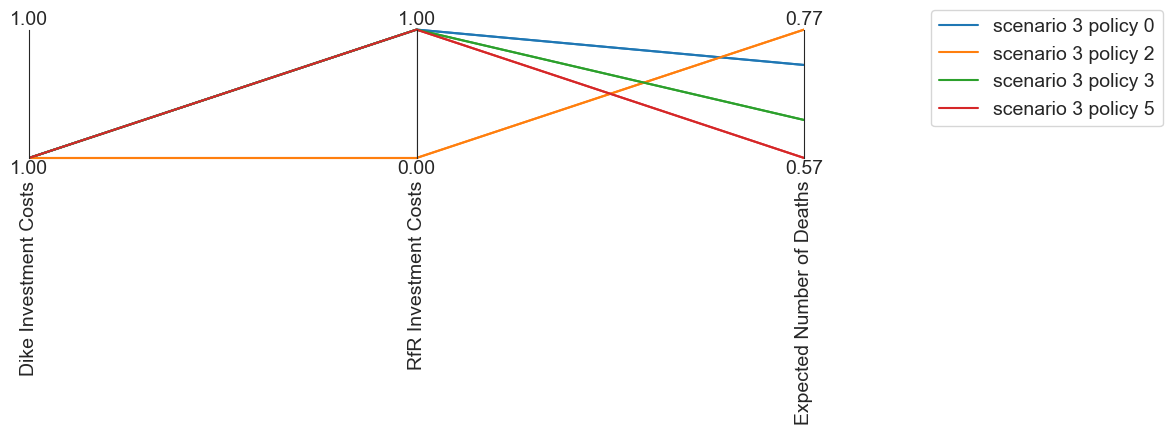

In [22]:
from ema_workbench.analysis import parcoords
import matplotlib.lines as mlines

limits = parcoords.get_limits(data_policies)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_policies)

policy_names = ['Policy 1', 'Policy 2', 'Policy 3', 'Policy 4']

for i, (name, color) in enumerate(zip(policy_names ,sns.color_palette())):
    paraxes.plot(data_policies.iloc[i].to_frame().T, color=color, label=name)

# we invert this axis so direction of desirability is the same  
paraxes.legend()
plt.savefig('../images/parcoord_robustness.png', dpi=300, bbox_inches = "tight")
plt.show()

In [23]:
outcomes_reev_df_policy  = outcomes_reev_df[outcomes_reev_df.policy == 'scenario 3 policy 0']
outcomes_reev_df_policy.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,500.000000
mean,3.342249e+07,1.300070e+08,1.060500e+09,1686.873825,0.002661
std,1.705510e+08,1.491608e-08,0.000000e+00,3490.984454,0.014551
min,0.000000e+00,1.300070e+08,1.060500e+09,0.000000,0.000000
25%,1.548206e+06,1.300070e+08,1.060500e+09,120.511279,0.000111
50%,6.783201e+06,1.300070e+08,1.060500e+09,564.471280,0.000465
75%,2.857263e+07,1.300070e+08,1.060500e+09,1864.936206,0.002000
max,2.685754e+09,1.300070e+08,1.060500e+09,42995.528439,0.202109


In [ ]:
experiments_reev.iloc[:,19:-1].drop_duplicates('policy').to_csv('../results/all_policies.csv')

In [ ]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments_reev['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data_regret = pd.DataFrame({outcome.name: outcomes_reev[outcome.name], 
                         "policy":experiments_reev['policy'],
                         "scenario":experiments_reev['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data_regret = data_regret.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data_regret.columns = data_regret.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data_regret.min(axis=1)[:, np.newaxis] - data_regret).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

In [ ]:
max_regret

In [ ]:
max_regret = pd.DataFrame(max_regret)

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=False, ax=ax)
plt.savefig('../images/policy_heatmap.png')
plt.show()

In [ ]:
colors = sns.color_palette()

data_regret = max_regret

limits = parcoords.get_limits(data_regret)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_regret)
plt.show()

In [ ]:
regret_death = max_regret.sort_values(by=['Expected Number of Deaths']).head()
regret_death

In [ ]:
regret_evac = max_regret.sort_values(by=['Evacuation Costs']).head()
# regret_evac = regret_damage.sort_values(by=['Expected Number of Deaths']).head()
regret_evac

In [ ]:
regret_damage = max_regret.sort_values(by=['Expected Annual Damage']).head()
# regret_damage = regret_damage.sort_values(by=['Expected Number of Deaths']).head()
regret_damage

In [ ]:
# regret_policies = [regret_death.index[0], regret_evac.index[0], regret_damage.index[0]]
# regret_policies

# regret_policies_df = max_regret[max_regret.index.isin(regret_policies)]
# regret_policies_df

regret_policies_df_2 = pd.concat([regret_death, regret_evac, regret_damage], axis=0)
regret_policies_df_2 = regret_policies_df_2[~regret_policies_df_2.index.duplicated(keep='first')]
regret_policies_df_2

In [ ]:
outcomes_reev_df_pol = data_domain[data_domain.index == 'scenario 2 policy 9']
outcomes_reev_df_pol

In [ ]:
from ema_workbench.analysis import parcoords
import matplotlib.lines as mlines

limits = parcoords.get_limits(regret_policies_df_2)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(regret_policies_df_2)

for i, (name, color) in enumerate(zip(regret_policies_df_2.index ,sns.color_palette())):
    paraxes.plot(regret_policies_df_2.iloc[i].to_frame().T, color=color, label=name)

paraxes.legend()

plt.show()

In [ ]:
import pandas as pd
from sklearn import preprocessing

x = regret_policies_df_2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
regret_policies_df_norm = pd.DataFrame(x_scaled, columns=regret_policies_df_2.columns)


limits = parcoords.get_limits(regret_policies_df_norm)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(regret_policies_df_norm)
plt.show()

In [ ]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [ ]:
policy_regret_filtered = { key: policy_regret[key] for key in regret_policies_df.index}

In [ ]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
# axes = [axes[0,0], axes[1,0]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret_filtered.items()):
    data_regret_plt = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data_regret_plt = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
fig.autofmt_xdate()
plt.show()

## select some policies from second metric and make boxplots

In [ ]:

def regret()
for outcome in dike_model.outcomes:
    policy_column = experiments_reev['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data_regret = pd.DataFrame({outcome.name: outcomes_reev[outcome.name], 
                         "policy":experiments_reev['policy'],
                         "scenario":experiments_reev['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data_regret = data_regret.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data_regret.columns = data_regret.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data_regret.min(axis=1)[:, np.newaxis] - data_regret).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

In [ ]:
total_scores = {}
for policy in experiments_reev.policy.unique():
    scores = {}
    logical = experiments_reev['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes_reev.items()}
    print(temp_outcomes)
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

In [ ]:
import functools

def robustness(direction, threshold, data):
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e3 # makes numbers nicer CAREFUL WITH UNITS
    
SMALLER = 'SMALLER'


max_num_deaths = 0.0001 * 3 * 5
max_rfr_costs = 1.1e9
max_dike_costs = 3.04e8

Expected_Annual_Damage = costs
Dike_Investment_Costs = functools.partial(robustness, SMALLER, max_dike_costs)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, max_num_deaths)
RfR_Investment_Costs = functools.partial(robustness, SMALLER, max_rfr_costs)
Evacuation_Costs = costs

In [ ]:
from ema_workbench.analysis import parcoords
import matplotlib.lines as mlines


funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths,
         'RfR Investment Costs':RfR_Investment_Costs,       
         'Evacuation Costs': Evacuation_Costs}

total_scores = {}
for policy in experiments_reev.policy.unique():
    scores = {}
    logical = experiments_reev['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes_reev.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data_domain = pd.DataFrame(total_scores).T#.reset_index(drop=True)
limits = parcoords.get_limits(data_domain)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_domain)
plt.legend()
plt.show()

# End of document